In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import os

In [68]:
# ============================================================
# Load raw data
# ============================================================
df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")
df_index_cn  = pd.read_csv("Project/Data/China/Index Profile170027150/IDX_Idxinfo.csv")

# Ensure index code is the same type in both tables
df_weekly_cn["Indexcd"] = df_weekly_cn["Indexcd"].astype(str)
df_index_cn["Indexcd"]  = df_index_cn["Indexcd"].astype(str)

/var/folders/wp/k5t4pl853ng8y6kktqkmy3n80000gn/T/ipykernel_45843/4064318882.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")


In [69]:
# ============================================================
# Read and merge all yearly US index files (2005–2025)
# ============================================================
csv_files = [
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2005.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2006.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2007.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2008.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2009.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2010.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2011.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2012.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2013.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2014.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2015.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2016.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2017.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2018.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2019.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2020.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2021.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2022.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2023.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2024.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2025.csv",
]

all_dfs_us = []
for fp in csv_files:
    df = pd.read_csv(fp)
    df["source_file"] = os.path.basename(fp)
    all_dfs_us.append(df)

merged_full_df_us = pd.concat(all_dfs_us, ignore_index=True)
out_merged_us = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv"
merged_full_df_us.to_csv(out_merged_us, index=False)
print(f"✅ Merged {len(csv_files)} files → {out_merged_us}")
print(f"   Total rows: {len(merged_full_df_us):,}")


✅ Merged 21 files → Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv
   Total rows: 7,157,595


In [70]:
# ============================================================
# Merge weekly quotes with index names
# ============================================================
merged_weekly_cn = pd.merge(
    df_weekly_cn,
    df_index_cn[["Indexcd", "Idxinfo01_en"]],   # only the columns we need
    on="Indexcd",
    how="left"
)

# Keep only relevant columns and rename for clarity
merged_weekly_cn = merged_weekly_cn[["Idxinfo01_en", "Indexcd", "Week", "Clsidx"]]
merged_weekly_cn.columns = ["EnglishName", "IndexCode", "Date", "Closing"]

display(merged_weekly_cn.head(10))

,EnglishName,IndexCode,Date,Closing
0,SSE Composite Index,000001,1991-01,131.44
1,SSE Composite Index,000001,1991-02,134.60
2,SSE Composite Index,000001,1991-03,134.24
3,SSE Composite Index,000001,1991-04,132.05
4,SSE Composite Index,000001,1991-05,129.51
5,SSE Composite Index,000001,1991-06,130.38
6,SSE Composite Index,000001,1991-07,132.53
7,SSE Composite Index,000001,1991-08,134.87
8,SSE Composite Index,000001,1991-09,132.53
9,SSE Composite Index,000001,1991-10,129.89


In [71]:
# index name for english name = x
index_name = "Transportation & Storage Index"
# Filter data for the specified index
index_data = merged_weekly_cn[merged_weekly_cn["EnglishName"] == index_name]
index_data

,EnglishName,IndexCode,Date,Closing
409655,Transportation & Storage Index,399160,2001-27,645.680
409656,Transportation & Storage Index,399160,2001-28,654.590
409657,Transportation & Storage Index,399160,2001-29,662.530
409658,Transportation & Storage Index,399160,2001-30,645.840
409659,Transportation & Storage Index,399160,2001-31,616.960
...,...,...,...,...
410236,Transportation & Storage Index,399160,2013-04,766.643
410237,Transportation & Storage Index,399160,2013-05,806.004
410238,Transportation & Storage Index,399160,2013-06,808.120
410239,Transportation & Storage Index,399160,2013-08,782.092


In [72]:
# ============================================================
# Keep only Fridays and normalize columns
# ============================================================
def keep_fridays(df: pd.DataFrame):
    """Detect date column, parse, and keep only Fridays."""
    date_col = None
    for cand in ["Trddt", "Date", "date", "DATE"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError("No date column found (expected one of: Trddt, Date, date, DATE).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df = df[df[date_col].dt.weekday == 4].copy()  # 4 = Friday
    return df, date_col

friday_parts = []
rows_before, rows_after = 0, 0

for fp in csv_files:
    tmp = pd.read_csv(fp)
    rows_before += len(tmp)
    tmp, dt_col = keep_fridays(tmp)
    tmp["source_file"] = os.path.basename(fp)
    rows_after += len(tmp)
    friday_parts.append(tmp)
    print(f"✔ {os.path.basename(fp)}: {len(tmp):,} Friday rows")

friday_df = pd.concat(friday_parts, ignore_index=True)

# keep useful columns if they exist
keep_cols = [c for c in ["Indexcd", "IndexName", "Clsidx", dt_col, "source_file"] if c in friday_df.columns]
friday_df = friday_df[keep_cols]

out_fridays = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_merged.csv"
friday_df.to_csv(out_fridays, index=False)

print("\n✅ Friday-only merge complete.")
print(f"   Rows before filter: {rows_before:,}")
print(f"   Rows after filter:  {rows_after:,}")
print(f"   Output: {out_fridays}")


✔ TRDA_Gidxtrd_2005.csv: 39,874 Friday rows
✔ TRDA_Gidxtrd_2006.csv: 77,199 Friday rows
✔ TRDA_Gidxtrd_2007.csv: 74,692 Friday rows
✔ TRDA_Gidxtrd_2008.csv: 109,679 Friday rows
✔ TRDA_Gidxtrd_2009.csv: 121,857 Friday rows
✔ TRDA_Gidxtrd_2010.csv: 116,933 Friday rows
✔ TRDA_Gidxtrd_2011.csv: 120,666 Friday rows
✔ TRDA_Gidxtrd_2012.csv: 122,046 Friday rows
✔ TRDA_Gidxtrd_2013.csv: 122,470 Friday rows
✔ TRDA_Gidxtrd_2014.csv: 113,143 Friday rows
✔ TRDA_Gidxtrd_2015.csv: 112,220 Friday rows
✔ TRDA_Gidxtrd_2016.csv: 115,264 Friday rows
✔ TRDA_Gidxtrd_2017.csv: 104,535 Friday rows
✔ TRDA_Gidxtrd_2018.csv: 40,131 Friday rows
✔ TRDA_Gidxtrd_2019.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2020.csv: 1,814 Friday rows
✔ TRDA_Gidxtrd_2021.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2022.csv: 1,888 Friday rows
✔ TRDA_Gidxtrd_2023.csv: 1,885 Friday rows
✔ TRDA_Gidxtrd_2024.csv: 1,815 Friday rows
✔ TRDA_Gidxtrd_2025.csv: 1,517 Friday rows

✅ Friday-only merge complete.
   Rows before filter: 7,157,595
   Rows a

In [74]:
us_cn_mapping = {
    "NASDAQ Health Care": [
        "CSI 800 Pharmaceuticals and Biotechnology Index",
        "CSI Health Care 100 Index",
        "Pharmaceutical & Biological Index",
        "SSE STAR Biology and Medicine Index"
    ],
    "NQ Biotechnology": [
        "SSE STAR Biology and Medicine Index",
        "CSI WIND Biotechnology Index"
    ],
    "NQ Computer": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Internet": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Industrial": [
        "SSE Upstream Industry Index",
        "SSE Midstream Industry Index",
        "SSE Downstream Industry Index",
        "CSI Midstream Manufacturing Industry Index"
    ],
    "NQ Transportation": [
        "Transportation & Storage Index",
        "CSI China Mainland Transportation index"
    ]
}


In [80]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# ------------------------------------------------------------
# 1) US weekly (friday_df): make YearWeek from actual dates
# ------------------------------------------------------------
for cand in ["Date", "Trddt", "date", "DATE"]:
    if cand in friday_df.columns:
        us_date_col = cand
        break
else:
    raise ValueError("No date column found in friday_df")

friday_df[us_date_col] = pd.to_datetime(friday_df[us_date_col], errors="coerce")
iso = friday_df[us_date_col].dt.isocalendar()
friday_df["YearWeek"] = iso.year.astype(str) + "-" + iso.week.astype(str).str.zfill(2)

# ------------------------------------------------------------
# 2) CN weekly (merged_weekly_us): already "YYYY-WW"
# ------------------------------------------------------------
merged_weekly_cn["YearWeek"] = merged_weekly_cn["Date"].astype(str)

# ------------------------------------------------------------
# 3) mapping US -> list of CN indices you want to test against
# ------------------------------------------------------------


# ------------------------------------------------------------
# helper: compute weekly log returns
# ------------------------------------------------------------
def compute_log_returns(df, price_col, out_col):
    df = df.sort_values("YearWeek").copy()
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[out_col] = np.log(df[price_col]).diff()
    return df[["YearWeek", out_col]].dropna()

# ------------------------------------------------------------
# helper: extract best (smallest) p-value from statsmodels result
# ------------------------------------------------------------
def best_granger_p(two_col_array: np.ndarray, maxlag: int) -> float:
    """
    two_col_array[:,0] = dependent
    two_col_array[:,1] = potential cause
    returns min p-value across lags
    """
    res = grangercausalitytests(two_col_array, maxlag=maxlag, verbose=False)
    pvals = []
    for lag, out in res.items():
        # out is usually a tuple: (testdict, extra)
        if isinstance(out, tuple):
            testdict = out[0]
        else:
            testdict = out
        if "ssr_ftest" in testdict:
            pvals.append(testdict["ssr_ftest"][1])
    return min(pvals) if pvals else np.nan

# ------------------------------------------------------------
# 4) run over all pairs
# ------------------------------------------------------------
max_lag = 4
rows = []

for us_name, cn_names in us_cn_mapping.items():
    # US slice
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        print(f"⚠️ US index '{us_name}' not found.")
        continue
    us_ret = compute_log_returns(us_sub, "Clsidx", "US_Ret")

    for cn_name in cn_names:
        cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
        if cn_sub.empty:
            print(f"⚠️ CN index '{cn_name}' not found.")
            continue
        cn_ret = compute_log_returns(cn_sub, "Closing", "CN_Ret")

        # align by YearWeek
        merged = pd.merge(us_ret, cn_ret, on="YearWeek", how="inner").dropna()
        if len(merged) < max_lag + 10:
            print(f"⚠️ {us_name} ↔ {cn_name}: too few common weeks ({len(merged)}).")
            continue

        data = merged[["US_Ret", "CN_Ret"]].to_numpy()


        rows.append(
            {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "n_obs": len(merged)
            }
        )

# results table
granger_results = pd.DataFrame(rows)
display(granger_results)


,US_Index,CN_Index,n_obs
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631
1,NASDAQ Health Care,CSI Health Care 100 Index,1106
2,NASDAQ Health Care,Pharmaceutical & Biological Index,368
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,284
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,284
5,NQ Biotechnology,CSI WIND Biotechnology Index,514
6,NQ Computer,SSE Information Technology Sector index,825
7,NQ Computer,CSI Information Technology index,1606
8,NQ Computer,SZSE Information Technology Sector Index,1018
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,394


In [83]:
# Keep only pairs with at least 520 overlapping weeks.
filtered = granger_results[
    (granger_results["n_obs"] >= 520)
].copy()

# Reset index for nicer display / downstream operations
filtered = filtered.reset_index(drop=True)
display(filtered)


,US_Index,CN_Index,n_obs
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631
1,NASDAQ Health Care,CSI Health Care 100 Index,1106
2,NQ Computer,SSE Information Technology Sector index,825
3,NQ Computer,CSI Information Technology index,1606
4,NQ Computer,SZSE Information Technology Sector Index,1018
5,NQ Computer,Information equipment,544
6,NQ Internet,SSE Information Technology Sector index,659
7,NQ Internet,CSI Information Technology index,1318
8,NQ Internet,SZSE Information Technology Sector Index,659
9,NQ Industrial,SSE Upstream Industry Index,711


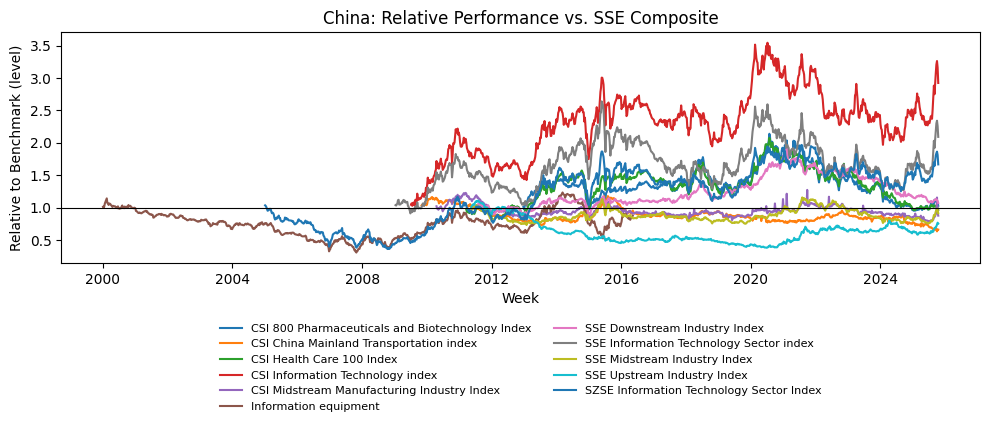

In [87]:
# Benchmark visualization of Chinese indices vs. SSE Composite Index

# -----------------------------
# Prepare list of CN indices
# -----------------------------
# Only the Chinese indices that appear in the filtered results are plotted.
cn_indices = sorted(filtered["CN_Index"].unique().tolist())

if len(cn_indices) == 0:
    raise ValueError("No Chinese indices found in 'filtered'. Check granger_results and the n_obs threshold.")

# -----------------------------
# Prepare Chinese weekly data
# -----------------------------
cn_df = merged_weekly_cn.copy()

# Ensure numeric closing values and mark non-positive as NaN
cn_df["Closing"] = pd.to_numeric(cn_df["Closing"], errors="coerce")
cn_df.loc[cn_df["Closing"] <= 0, "Closing"] = np.nan

# Convert ISO week string "YYYY-WW" to a concrete week-start date (Monday)
def iso_week_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

# Create WeekStart column used as time index
cn_df["WeekStart"] = cn_df["Date"].astype(str).apply(iso_week_to_date)

# Keep only rows for the relevant Chinese indices
cn_df = cn_df[cn_df["EnglishName"].isin(cn_indices)].copy()

# If multiple entries per (index, week) exist, aggregate by mean closing price
cn_df = (
    cn_df
    .groupby(["EnglishName", "WeekStart"], as_index=False)["Closing"]
    .mean()
    .sort_values(["EnglishName", "WeekStart"])
)

# Compute weekly log returns per index
cn_df["LogReturn"] = np.log(cn_df["Closing"]).groupby(cn_df["EnglishName"]).diff()

# Pivot to get weeks × indices matrix of returns
cn_pivot = cn_df.pivot(index="WeekStart", columns="EnglishName", values="LogReturn").sort_index()

# -----------------------------
# Add SSE Composite Index as benchmark if missing
# -----------------------------
benchmark_name = "SSE Composite Index"
if benchmark_name not in cn_pivot.columns:
    extra = merged_weekly_cn[merged_weekly_cn["EnglishName"] == benchmark_name].copy()
    extra["Closing"] = pd.to_numeric(extra["Closing"], errors="coerce")
    extra["WeekStart"] = extra["Date"].astype(str).apply(iso_week_to_date)
    extra = (
        extra.groupby(["WeekStart"], as_index=False)["Closing"]
        .mean()
        .sort_values("WeekStart")
    )
    extra["LogReturn"] = np.log(extra["Closing"]).diff()
    cn_pivot[benchmark_name] = extra.set_index("WeekStart")["LogReturn"]

# Keep only weeks where the benchmark has data (aligns all series to benchmark availability)
cn_pivot = cn_pivot.dropna(subset=[benchmark_name])

# -----------------------------
# Plot relative performance vs. benchmark
# -----------------------------
plt.figure(figsize=(10, 5))

plotted_any = False
for col in cn_indices:
    # Skip benchmark column and any index not in the pivot (e.g., due to missing data)
    if col == benchmark_name or col not in cn_pivot:
        continue
    pair = cn_pivot[[benchmark_name, col]].dropna()
    if pair.empty:
        continue

    # cumulative excess log return -> convert to level relative to 1
    ex_ret = (pair[col] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)

    plt.plot(rel_series.index, rel_series.values, label=f"{col}")
    plotted_any = True

if not plotted_any:
    raise ValueError("No series plotted: check that cn_indices exist in merged_weekly_cn and have enough data.")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title("China: Relative Performance vs. SSE Composite", fontsize=12)
plt.ylabel("Relative to Benchmark (level)")
plt.xlabel("Week")

# Legend below the plot, centered
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=2,
    fontsize=8,
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # leave space for the legend below the figure
plt.show()

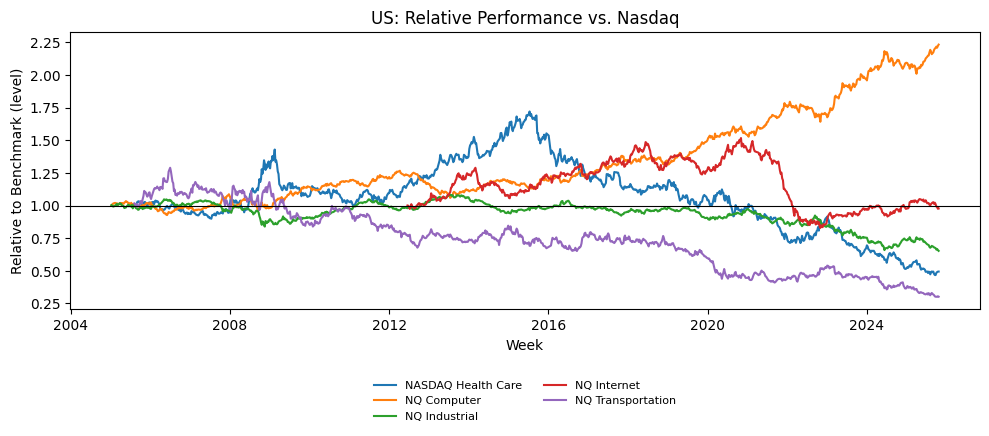

In [ ]:
# Visualization of US indices vs. Nasdaq Benchmark

# List of unique US indices to plot
us_indices = sorted(filtered["US_Index"].unique().tolist())

if len(us_indices) == 0:
    raise ValueError("No US indices found in 'filtered'. Check granger_results and the filtering thresholds.")

# -----------------------------
# 2) Prepare US weekly data
# -----------------------------
us_df = friday_df.copy()

# Ensure numeric price column and drop non-positive values
us_df["Clsidx"] = pd.to_numeric(us_df["Clsidx"], errors="coerce")
us_df.loc[us_df["Clsidx"] <= 0, "Clsidx"] = np.nan

# Convert YearWeek string "YYYY-WW" to a concrete week-start date (Monday)
def yearweek_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

us_df["WeekStart"] = us_df["YearWeek"].astype(str).apply(yearweek_to_date)

# Keep only required indices: all filtered US indices plus the benchmark
need_names = set(us_indices) | {benchmark_name}
us_df = us_df[us_df["IndexName"].isin(need_names)].copy()

# Aggregate multiple entries per (IndexName, WeekStart) by mean
us_df = (
    us_df
    .groupby(["IndexName", "WeekStart"], as_index=False)["Clsidx"]
    .mean()
    .sort_values(["IndexName", "WeekStart"])
)

# Compute weekly log returns per index
us_df["LogReturn"] = np.log(us_df["Clsidx"]).groupby(us_df["IndexName"]).diff()

# Pivot to weeks × indices
us_pivot = us_df.pivot(index="WeekStart", columns="IndexName", values="LogReturn").sort_index()

# -----------------------------
# 3) Ensure benchmark is present
# -----------------------------
benchmark_name = "Nasdaq"
if benchmark_name not in us_pivot.columns:
    # try to extract benchmark from friday_df (same source)
    extra = friday_df[friday_df["IndexName"] == benchmark_name].copy()
    if extra.empty:
        raise ValueError(f"Benchmark '{benchmark_name}' not found in friday_df. Please ensure benchmark data are available.")
    extra["Clsidx"] = pd.to_numeric(extra["Clsidx"], errors="coerce")
    extra["WeekStart"] = extra["YearWeek"].astype(str).apply(yearweek_to_date)
    extra = (
        extra.groupby(["WeekStart"], as_index=False)["Clsidx"]
        .mean()
        .sort_values("WeekStart")
    )
    extra["LogReturn"] = np.log(extra["Clsidx"]).diff()
    us_pivot[benchmark_name] = extra.set_index("WeekStart")["LogReturn"]

# Keep only weeks with benchmark data to align all series
us_pivot = us_pivot.dropna(subset=[benchmark_name])

# -----------------------------
# 4) Plot relative performance vs. benchmark
# -----------------------------
plt.figure(figsize=(10, 5))

plotted_any = False
for name in us_indices:
    # Skip benchmark itself and any names not present in the pivot
    if name == benchmark_name or name not in us_pivot:
        continue
    pair = us_pivot[[benchmark_name, name]].dropna()
    if pair.empty:
        continue

    # cumulative excess log return -> convert to level relative to 1
    ex_ret = (pair[name] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)

    plt.plot(rel_series.index, rel_series.values, label=f"{name}")
    plotted_any = True

if not plotted_any:
    raise ValueError("No series plotted: check that us_indices exist in friday_df and have enough data.")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title(f"US: Relative Performance vs. {benchmark_name}", fontsize=12)
plt.ylabel("Relative to Benchmark (level)")
plt.xlabel("Week")

# Legend below the plot; adjust ncol depending on the number of series
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=2,
    fontsize=8,
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # leave space for the legend
plt.show()

In [90]:
# Parameter
MAX_LAG = 26

def granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Erwartet ein DataFrame aus make_pair_timeseries mit Spalten:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    und berechnet p-Werte für CN→US.
    """
    df = pair_df[["US_Ret", "CN_Ret"]].dropna()
    arr = df[["US_Ret", "CN_Ret"]].to_numpy()  # US zuerst, CN zweite Spalte -> CN→US
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p

rows = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        # 1) Daten für genau dieses Paar bauen
        pair_df = make_pair_timeseries(
            friday_df,
            merged_weekly_cn,
            us_name=us_name,
            cn_name=cn_name
        )
        # falls es für ein Paar keine Daten gibt, überspringen
        if pair_df is None or pair_df.empty:
            continue

        # 2) Granger p-Werte holen
        try:
            lag_p = granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG)
        except Exception as e:
            # falls mal was schiefgeht (zu wenige Zeilen o.ä.), trotzdem eine Zeile schreiben
            row = {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "direction": "CN→US",
                "error": str(e)
            }
            rows.append(row)
            continue

        # 3) Zeile bauen
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        # kleinsten p-Wert merken
        row["min_p_value"] = min(v for v in lag_p.values() if pd.notna(v))
        rows.append(row)

# 4) DataFrame
granger_df = pd.DataFrame(rows)

# 5) Styling
def highlight_pvals(val):
    if pd.isna(val):
        return ""
    if val < 0.05:
        return "background-color: #a8e6a1"  # grün
    elif val < 0.1:
        return "background-color: #fff3b0"  # gelb


lag_cols = [c for c in granger_df.columns if c.startswith("Lag_")]

styled = (
    granger_df
    .style
    .applymap(highlight_pvals, subset=lag_cols)
    .background_gradient(subset=["min_p_value"], cmap="RdYlGn_r")
    .format("{:.4f}", subset=lag_cols + ["min_p_value"])
)

styled

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,min_p_value,error
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,0.0707,0.1499,0.1442,0.2654,0.2466,0.3645,0.4341,0.5027,0.5686,0.5191,0.6228,0.6852,0.4164,0.4352,0.4816,0.5390,0.6217,0.3745,0.4495,0.5317,0.5223,0.5279,0.6009,0.6862,0.7425,0.7413,0.0707,nan
1,NASDAQ Health Care,CSI Health Care 100 Index,CN→US,0.7557,0.2910,0.4653,0.5796,0.6649,0.0282,0.0421,0.0777,0.1147,0.0361,0.0612,0.0166,0.0228,0.0291,0.0384,0.0377,0.0312,0.0327,0.0277,0.0346,0.0480,0.0401,0.0544,0.0851,0.0874,0.1066,0.0166,nan
2,NASDAQ Health Care,Pharmaceutical & Biological Index,CN→US,0.7693,0.8463,0.9339,0.9421,0.9812,0.9927,0.9978,0.9769,0.9815,0.9779,0.9918,0.9260,0.9113,0.9405,0.8333,0.8316,0.7867,0.7783,0.8298,0.8284,0.8255,0.8514,0.7710,0.7367,0.7445,0.7256,0.7256,nan
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,CN→US,0.4641,0.7427,0.8160,0.6568,0.7820,0.4604,0.4902,0.5011,0.5000,0.1750,0.1563,0.1048,0.1197,0.1772,0.1337,0.2111,0.1686,0.1689,0.2286,0.2729,0.3471,0.3862,0.4628,0.5514,0.3850,0.4354,0.1048,nan
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,CN→US,0.5054,0.6090,0.7208,0.6076,0.7327,0.3706,0.3873,0.3702,0.3982,0.1288,0.1392,0.0956,0.0927,0.1413,0.1024,0.1575,0.1250,0.0941,0.1115,0.1441,0.2012,0.2172,0.2168,0.3000,0.2058,0.2376,0.0927,nan
5,NQ Biotechnology,CSI WIND Biotechnology Index,CN→US,0.1764,0.3570,0.5447,0.6772,0.4856,0.4864,0.4130,0.3761,0.2993,0.3340,0.3808,0.4355,0.2692,0.0929,0.1317,0.2345,0.2542,0.2752,0.2709,0.2414,0.2907,0.3280,0.3910,0.4082,0.3534,0.3652,0.0929,nan
6,NQ Computer,SSE Information Technology Sector index,CN→US,0.2574,0.4582,0.2695,0.4289,0.5634,0.7139,0.8684,0.6722,0.7338,0.7193,0.7958,0.8257,0.8334,0.8808,0.8549,0.8636,0.8929,0.9201,0.9527,0.9690,0.9695,0.8674,0.8298,0.8459,0.8920,0.8801,0.2574,nan
7,NQ Computer,CSI Information Technology index,CN→US,0.9955,0.5719,0.7728,0.9140,0.9644,0.2333,0.3271,0.3608,0.4584,0.6457,0.7300,0.7697,0.8314,0.8726,0.9108,0.8573,0.8962,0.8886,0.9196,0.9172,0.9409,0.9283,0.9485,0.9615,0.9732,0.9271,0.2333,nan
8,NQ Computer,SZSE Information Technology Sector Index,CN→US,0.8841,0.7531,0.6325,0.3966,0.4681,0.5494,0.6180,0.4014,0.5031,0.5489,0.4130,0.3508,0.2251,0.2857,0.1876,0.1945,0.1631,0.1728,0.1792,0.2421,0.1753,0.2027,0.2249,0.2113,0.1801,0.1746,0.1631,nan
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,CN→US,0.5735,0.6601,0.8055,0.3308,0.5579,0.6566,0.5570,0.5264,0.6367,0.6839,0.3776,0.3025,0.2805,0.2559,0.1548,0.1657,0.0866,0.0849,0.1037,0.1092,0.1172,0.1157,0.1467,0.0795,0.1170,0.1356,0.0795,nan


In [91]:
# Parameter
MAX_LAG = 26

def granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Erwartet ein DataFrame aus make_pair_timeseries mit Spalten:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    und berechnet p-Werte für CN→US.
    """
    df = pair_df[["CN_Ret", "US_Ret"]].dropna()
    arr = df[["CN_Ret", "US_Ret"]].to_numpy()  # US zuerst, CN zweite Spalte -> CN→US
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p

rows = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        # 1) Daten für genau dieses Paar bauen
        pair_df = make_pair_timeseries(
            friday_df,
            merged_weekly_cn,
            us_name=us_name,
            cn_name=cn_name
        )
        # falls es für ein Paar keine Daten gibt, überspringen
        if pair_df is None or pair_df.empty:
            continue

        # 2) Granger p-Werte holen
        try:
            lag_p = granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG)
        except Exception as e:
            # falls mal was schiefgeht (zu wenige Zeilen o.ä.), trotzdem eine Zeile schreiben
            row = {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "direction": "US->CN",
                "error": str(e)
            }
            rows.append(row)
            continue

        # 3) Zeile bauen
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US->CN",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        # kleinsten p-Wert merken
        row["min_p_value"] = min(v for v in lag_p.values() if pd.notna(v))
        rows.append(row)

# 4) DataFrame
granger_df = pd.DataFrame(rows)

# 5) Styling
def highlight_pvals(val):
    if pd.isna(val):
        return ""
    if val < 0.05:
        return "background-color: #a8e6a1"  # grün
    elif val < 0.1:
        return "background-color: #fff3b0"  # gelb


lag_cols = [c for c in granger_df.columns if c.startswith("Lag_")]

styled = (
    granger_df
    .style
    .applymap(highlight_pvals, subset=lag_cols)
    .background_gradient(subset=["min_p_value"], cmap="RdYlGn_r")
    .format("{:.4f}", subset=lag_cols + ["min_p_value"])
)

styled

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,min_p_value,error
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,US->CN,0.0757,0.2172,0.4017,0.5230,0.4598,0.5483,0.6323,0.7186,0.6467,0.7042,0.3886,0.1938,0.1420,0.1587,0.2208,0.2596,0.2737,0.2991,0.3209,0.3785,0.1225,0.1465,0.1543,0.1511,0.1801,0.2275,0.0757,nan
1,NASDAQ Health Care,CSI Health Care 100 Index,US->CN,0.5775,0.2200,0.3875,0.3855,0.4710,0.5982,0.7171,0.6056,0.6560,0.6389,0.4172,0.0716,0.0877,0.1086,0.1477,0.1515,0.1065,0.1282,0.1447,0.1883,0.1656,0.0959,0.1487,0.1254,0.1354,0.0232,0.0232,nan
2,NASDAQ Health Care,Pharmaceutical & Biological Index,US->CN,0.1291,0.2380,0.2017,0.3169,0.2976,0.1993,0.2938,0.3545,0.4260,0.1834,0.2404,0.2969,0.3252,0.3515,0.3669,0.3511,0.4080,0.4772,0.5959,0.4942,0.5187,0.6004,0.5991,0.6422,0.7151,0.6870,0.1291,nan
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,US->CN,0.3400,0.6204,0.8129,0.7887,0.8728,0.9254,0.8698,0.9123,0.9353,0.9715,0.8767,0.5903,0.5937,0.6862,0.6810,0.7148,0.6554,0.5825,0.4494,0.3905,0.3411,0.2643,0.2613,0.3351,0.3653,0.3458,0.2613,nan
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,US->CN,0.5289,0.7869,0.8574,0.8000,0.8890,0.9475,0.9204,0.9468,0.9307,0.9755,0.9401,0.7859,0.7217,0.8147,0.8323,0.8764,0.8417,0.8109,0.7512,0.6707,0.6460,0.6043,0.6194,0.6330,0.6721,0.6331,0.5289,nan
5,NQ Biotechnology,CSI WIND Biotechnology Index,US->CN,0.3570,0.6176,0.7146,0.7442,0.5163,0.4642,0.5224,0.5457,0.6078,0.6690,0.6721,0.6411,0.6508,0.7236,0.8022,0.8186,0.6106,0.6180,0.6782,0.7366,0.3924,0.4371,0.4365,0.4920,0.5110,0.5704,0.3570,nan
6,NQ Computer,SSE Information Technology Sector index,US->CN,0.0078,0.0031,0.0036,0.0094,0.0082,0.0106,0.0101,0.0194,0.0092,0.0153,0.0245,0.0337,0.0513,0.0662,0.1012,0.1361,0.0788,0.0440,0.0528,0.0720,0.1066,0.1226,0.0867,0.1055,0.1071,0.0505,0.0031,nan
7,NQ Computer,CSI Information Technology index,US->CN,0.9261,0.0036,0.0105,0.0000,0.0001,0.0003,0.0006,0.0010,0.0020,0.0006,0.0012,0.0004,0.0007,0.0004,0.0008,0.0010,0.0016,0.0006,0.0009,0.0008,0.0014,0.0016,0.0025,0.0016,0.0024,0.0031,0.0000,nan
8,NQ Computer,SZSE Information Technology Sector Index,US->CN,0.0001,0.0000,0.0001,0.0003,0.0003,0.0003,0.0002,0.0001,0.0002,0.0001,0.0001,0.0002,0.0002,0.0004,0.0006,0.0005,0.0002,0.0002,0.0002,0.0005,0.0008,0.0009,0.0009,0.0012,0.0018,0.0004,0.0000,nan
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,US->CN,0.0000,0.0002,0.0005,0.0016,0.0018,0.0019,0.0040,0.0026,0.0050,0.0051,0.0079,0.0125,0.0153,0.0350,0.0430,0.0294,0.0377,0.0534,0.0534,0.0689,0.0927,0.1351,0.1679,0.1800,0.2624,0.1938,0.0000,nan


In [48]:
top = granger_df.sort_values("min_p_value").head(3)
top


,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,...,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,min_p_value,error
19,NQ Industrial,CSI Midstream Manufacturing Industry Index,US->CN,0.012373,0.002477,0.000972,0.000028,0.000004,0.000004,0.000012,...,0.000502,0.000664,0.002025,0.002631,0.003742,0.006813,0.007284,0.006887,0.000004,NaN
7,NQ Computer,CSI Information Technology index,US->CN,0.926081,0.003609,0.010525,0.000025,0.000072,0.000250,0.000573,...,0.000949,0.000847,0.001372,0.001601,0.002493,0.001592,0.002441,0.003100,0.000025,NaN
21,NQ Transportation,CSI China Mainland Transportation index,US->CN,0.000118,0.000028,0.000041,0.000035,0.000081,0.000051,0.000044,...,0.000162,0.000232,0.000331,0.000556,0.000952,0.001209,0.001342,0.001565,0.000028,NaN


In [49]:
def get_overlap_period(friday_df, merged_weekly_cn, us_name, cn_name):
    pair = make_pair_timeseries(
        friday_df, merged_weekly_cn,
        us_name=us_name,
        cn_name=cn_name
    )
    if pair is None or pair.empty:
        return None
    
    start = pair["Date"].min().date()
    end   = pair["Date"].max().date()
    return start, end, len(pair)

overlaps = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        try:
            result = get_overlap_period(friday_df, merged_weekly_cn, us_name, cn_name)
            if result:
                start, end, n = result
                overlaps.append({
                    "US_Index": us_name,
                    "CN_Index": cn_name,
                    "Overlap_Start": start,
                    "Overlap_End": end,
                    "n_weeks": n
                })
        except Exception:
            continue

overlap_df = pd.DataFrame(overlaps)
display(overlap_df)


,US_Index,CN_Index,Overlap_Start,Overlap_End,n_weeks
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,2012-12-24,2025-10-13,631
1,NASDAQ Health Care,CSI Health Care 100 Index,2011-03-14,2025-10-13,1106
2,NASDAQ Health Care,Pharmaceutical & Biological Index,2005-08-08,2013-02-25,368
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,2020-01-06,2025-10-13,284
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,2020-01-06,2025-10-13,284
5,NQ Biotechnology,CSI WIND Biotechnology Index,2015-05-11,2025-10-13,514
6,NQ Computer,SSE Information Technology Sector index,2009-01-12,2025-10-13,825
7,NQ Computer,CSI Information Technology index,2009-07-06,2025-10-13,1605
8,NQ Computer,SZSE Information Technology Sector Index,2005-01-10,2025-10-13,1018
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,2005-01-10,2013-02-25,394


In [50]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import numpy as np

# 1. Top-3-Paare aus deiner großen Tabelle
top3 = granger_df.sort_values("min_p_value").head(3)

results = []

for _, row in top3.iterrows():
    us = row["US_Index"]
    cn = row["CN_Index"]

    # 2. Daten für genau dieses Paar holen
    pair_df = make_pair_timeseries(
        friday_df,
        merged_weekly_cn,
        us_name=us,
        cn_name=cn
    )
    pair_df = pair_df.dropna(subset=["US_Ret", "CN_Ret"])

    # falls zu wenig Daten: überspringen
    if len(pair_df) < 30:
        results.append({
            "US_Index": us,
            "CN_Index": cn,
            "N": len(pair_df),
            "GC_CN_to_US_p_min_lag4": np.nan,
            "GC_US_to_CN_p_min_lag4": np.nan,
            "VAR_CN_to_US_p": np.nan,
            "VAR_US_to_CN_p": np.nan,
            "note": "zu wenig Daten"
        })
        continue

    # 3. Granger: CN -> US
    arr_cn_us = pair_df[["US_Ret", "CN_Ret"]].to_numpy()
    gc_cn_us = grangercausalitytests(arr_cn_us, maxlag=4, verbose=False)
    p_cn_us = [gc_cn_us[lag][0]["ssr_ftest"][1] for lag in range(1, 5)]
    p_cn_us_min = min(p_cn_us)

    # 4. Granger: US -> CN
    arr_us_cn = pair_df[["CN_Ret", "US_Ret"]].to_numpy()
    gc_us_cn = grangercausalitytests(arr_us_cn, maxlag=4, verbose=False)
    p_us_cn = [gc_us_cn[lag][0]["ssr_ftest"][1] for lag in range(1, 5)]
    p_us_cn_min = min(p_us_cn)

    # 5. VAR schätzen
    var_mod = VAR(pair_df[["US_Ret", "CN_Ret"]])
    var_res = var_mod.fit(maxlags=26)

    # VAR-Causality: CN -> US
    var_gc_cn_us = var_res.test_causality("US_Ret", ["CN_Ret"], kind="f")
    p_var_cn_us = var_gc_cn_us.pvalue

    # VAR-Causality: US -> CN
    var_gc_us_cn = var_res.test_causality("CN_Ret", ["US_Ret"], kind="f")
    p_var_us_cn = var_gc_us_cn.pvalue

    results.append({
        "US_Index": us,
        "CN_Index": cn,
        "N": len(pair_df),
        "GC_CN_to_US_p_min_lag4": p_cn_us_min,
        "GC_US_to_CN_p_min_lag4": p_us_cn_min,
        "VAR_CN_to_US_p": p_var_cn_us,
        "VAR_US_to_CN_p": p_var_us_cn,
        "note": ""
    })

summary_df = pd.DataFrame(results)
summary_df


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,N,GC_CN_to_US_p_min_lag4,GC_US_to_CN_p_min_lag4,VAR_CN_to_US_p,VAR_US_to_CN_p,note
0,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.180120,0.000028,0.089675,0.006553,
1,NQ Computer,CSI Information Technology index,1605,0.571896,0.000025,0.927642,0.002924,
2,NQ Transportation,CSI China Mainland Transportation index,1545,0.850797,0.000028,0.872167,0.001456,


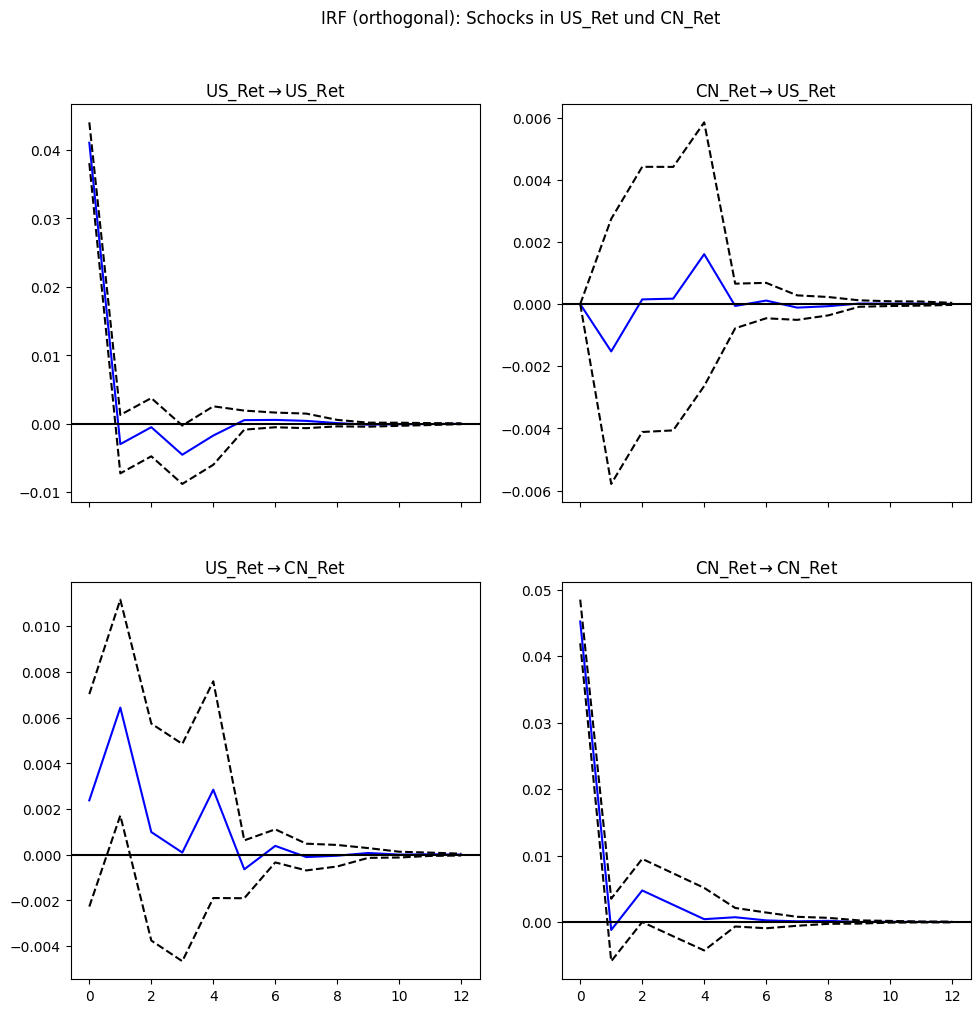

In [51]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

def prepare_pair_ts(friday_df, merged_weekly_cn, us_name, cn_name):
    pair_df = make_pair_timeseries(
        friday_df,
        merged_weekly_cn,
        us_name=us_name,
        cn_name=cn_name
    )
    pair_df = pair_df.dropna(subset=["US_Ret", "CN_Ret"]).copy()
    # Reihenfolge festlegen: erst US, dann CN
    return pair_df[["US_Ret", "CN_Ret"]]

def run_var_and_irf(pair_df, maxlags=4, irf_horizon=12):
    model = VAR(pair_df)
    res = model.fit(maxlags)
    irf = res.irf(irf_horizon)

    # Plot: Wirkung eines CN-Schocks auf US
    fig = irf.plot(orth=True)
    plt.suptitle("IRF (orthogonal): Schocks in US_Ret und CN_Ret", y=1.02)
    plt.show()

    return res, irf

# Beispiel für eines deiner drei Paare
us = "NQ Transportation"
cn = "Transportation & Storage Index"

pair_df = prepare_pair_ts(friday_df, merged_weekly_cn, us, cn)
res, irf = run_var_and_irf(pair_df, maxlags=4, irf_horizon=12)


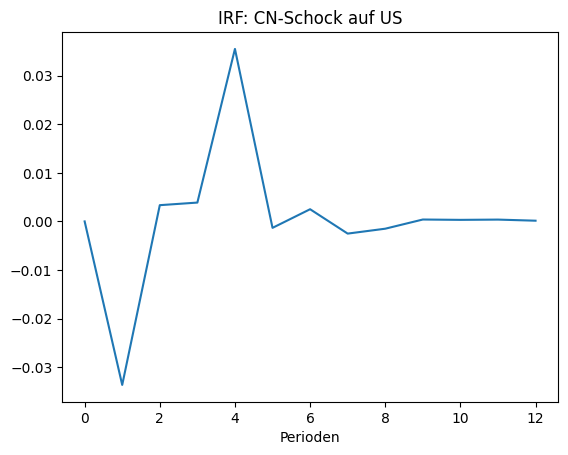

In [52]:
# Effekt von CN_Ret (2) auf US_Ret (1)
cn_on_us = irf.irfs[:, 0, 1]  # [horizont, ziel=0=US, schock=1=CN]

plt.plot(cn_on_us)
plt.title("IRF: CN-Schock auf US")
plt.xlabel("Perioden")
plt.show()


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

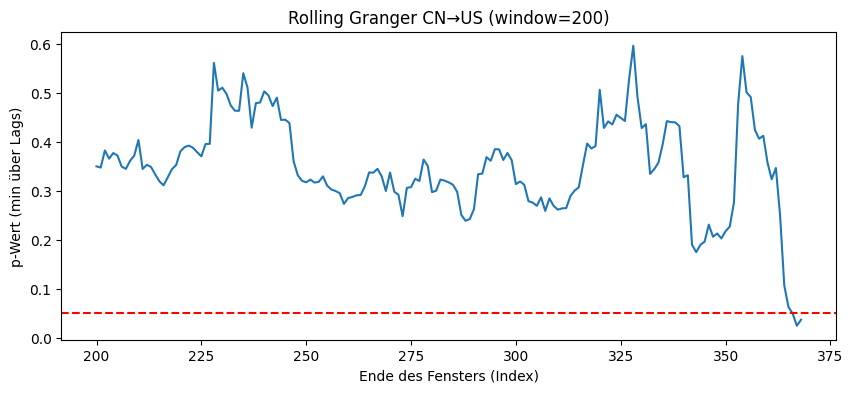

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd

def rolling_granger_cn_to_us(pair_df, maxlag=4, window=200):
    """
    pair_df: DataFrame mit Spalten US_Ret, CN_Ret (keine NaNs)
    maxlag: Granger maxlag
    window: Fenstergröße (Anzahl Beobachtungen pro Rolling-Schätzung)
    """
    df = pair_df[["US_Ret", "CN_Ret"]].dropna().reset_index(drop=True)
    n = len(df)
    results = []

    for start in range(0, n - window + 1):
        end = start + window
        sub = df.iloc[start:end]
        arr = sub[["US_Ret", "CN_Ret"]].to_numpy()  # CN -> US
        try:
            gc = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
            # z.B. Minimum über alle Lags im Fenster
            pvals = [gc[lag][0]["ssr_ftest"][1] for lag in range(1, maxlag+1)]
            pmin = min(pvals)
        except Exception as e:
            pmin = np.nan

        results.append({
            "start_idx": start,
            "end_idx": end,
            "pmin": pmin
        })

    return pd.DataFrame(results)

# Beispiel für dein erstes Paar
pair_df = prepare_pair_ts(friday_df, merged_weekly_cn,
                          "NQ Transportation",
                          "Transportation & Storage Index")

roll_df = rolling_granger_cn_to_us(pair_df, maxlag=4, window=200)

# Plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(roll_df["end_idx"], roll_df["pmin"])
plt.axhline(0.05, color="red", linestyle="--")
plt.title("Rolling Granger CN→US (window=200)")
plt.xlabel("Ende des Fensters (Index)")
plt.ylabel("p-Wert (min über Lags)")
plt.show()



=== NQ Transportation  <--->  Transportation & Storage Index ===


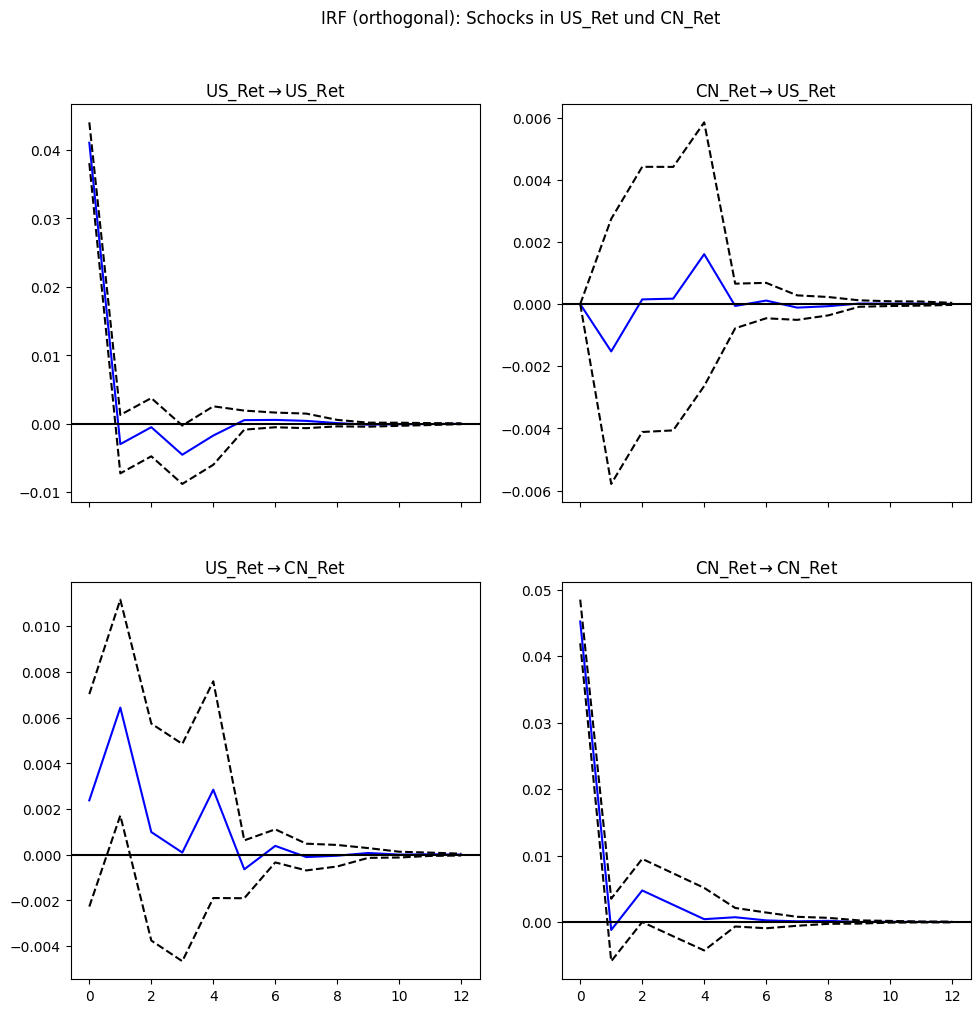

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

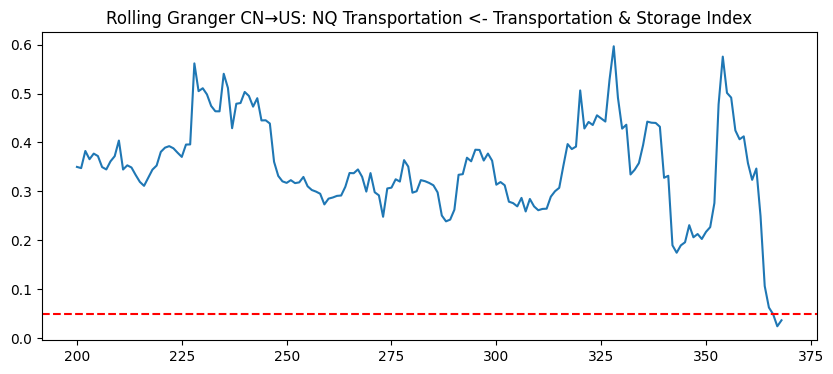


=== NASDAQ Health Care  <--->  CSI Health Care 100 Index ===


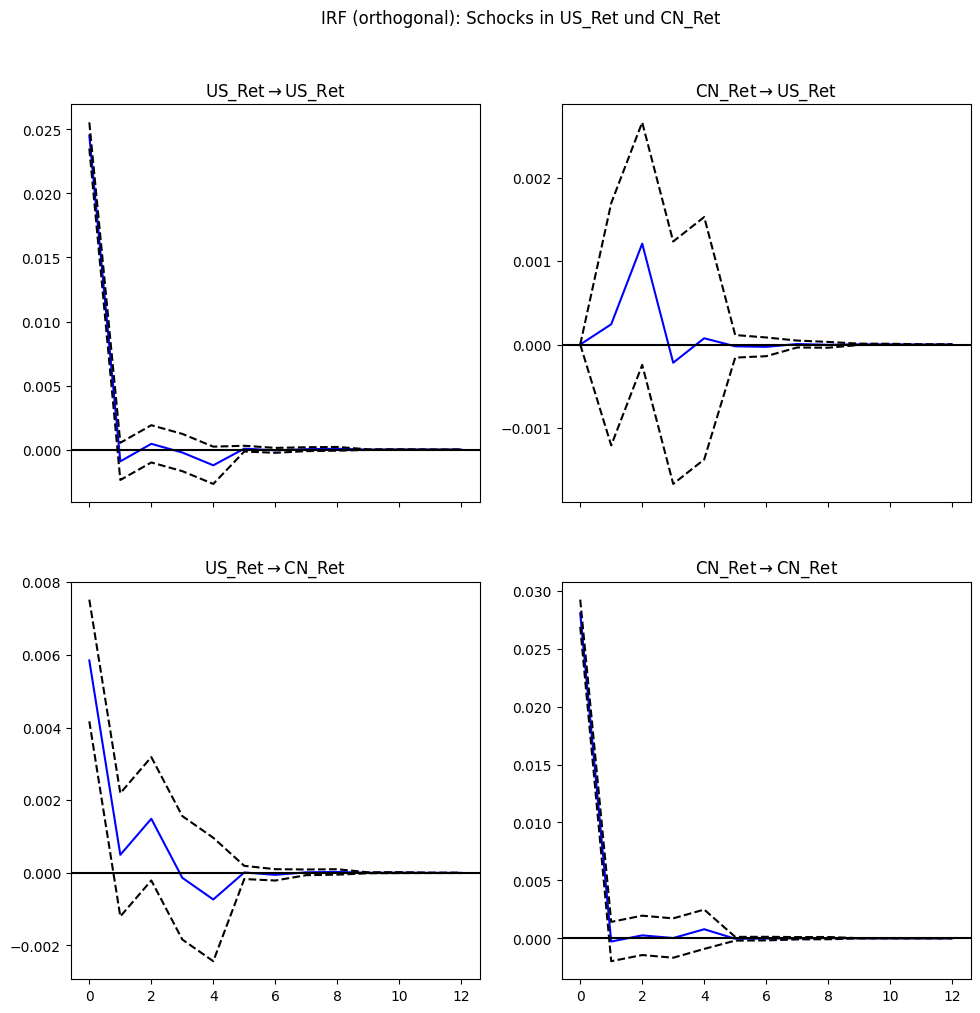

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

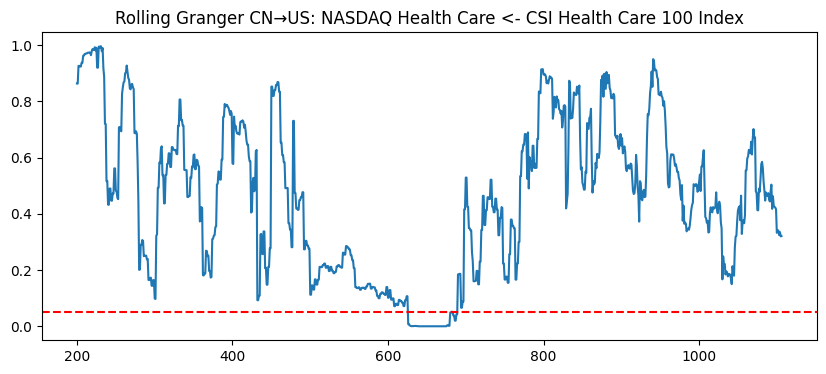


=== NQ Computer  <--->  Information equipment ===


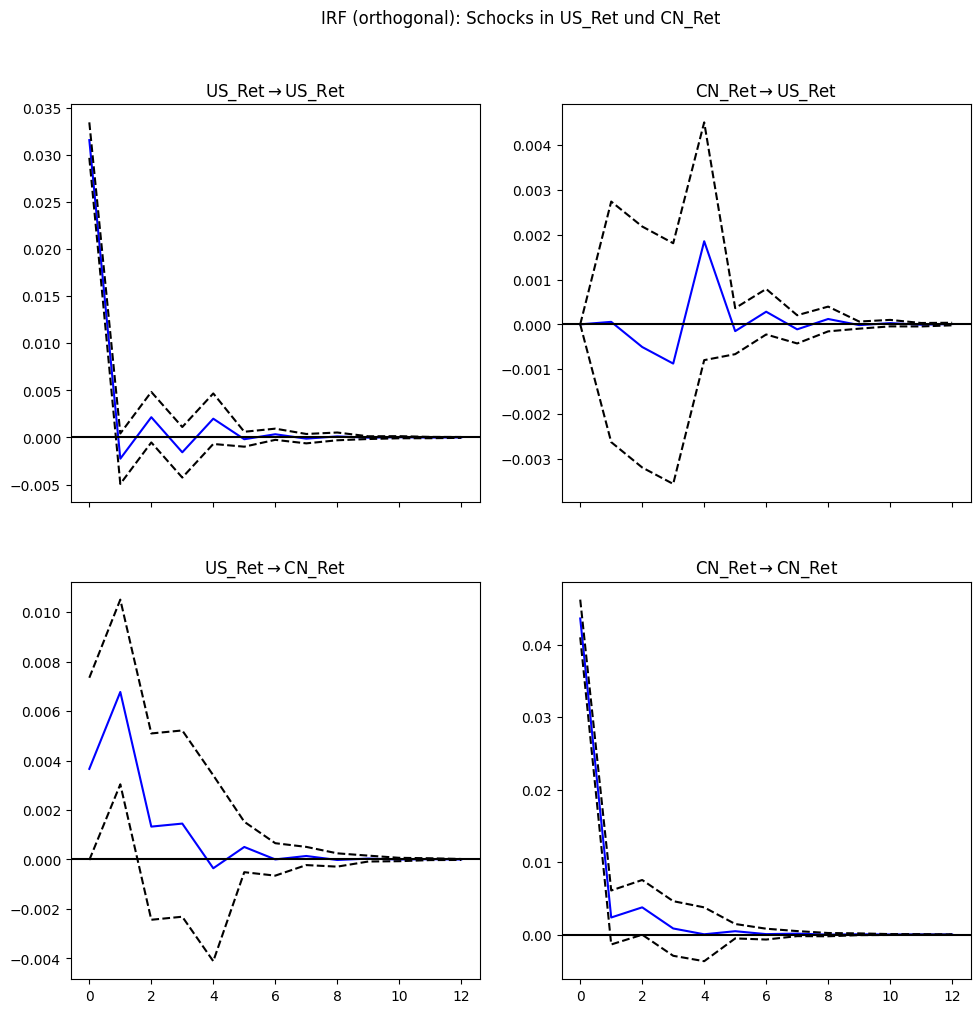

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

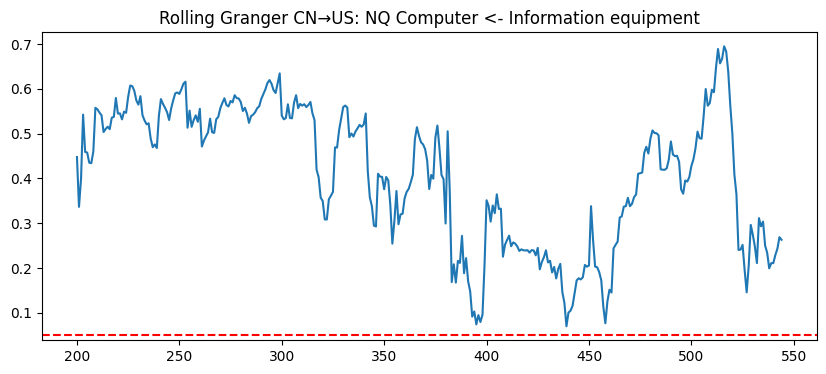

In [54]:
top_pairs = [
    ("NQ Transportation", "Transportation & Storage Index"),
    ("NASDAQ Health Care", "CSI Health Care 100 Index"),
    ("NQ Computer", "Information equipment"),
]

for us, cn in top_pairs:
    print(f"\n=== {us}  <--->  {cn} ===")
    pair_df = prepare_pair_ts(friday_df, merged_weekly_cn, us, cn)

    # VAR + IRF
    res, irf = run_var_and_irf(pair_df, maxlags=4, irf_horizon=12)

    # Rolling Granger
    roll_df = rolling_granger_cn_to_us(pair_df, maxlag=4, window=200)
    plt.figure(figsize=(10,4))
    plt.plot(roll_df["end_idx"], roll_df["pmin"])
    plt.axhline(0.05, color="red", linestyle="--")
    plt.title(f"Rolling Granger CN→US: {us} <- {cn}")
    plt.show()


In [55]:
import pandas as pd
import numpy as np

def yearweek_to_monday(yearweek: str) -> pd.Timestamp:
    year, week = yearweek.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)  # Montag der ISO-Woche

def make_pair_timeseries(
    friday_df: pd.DataFrame,
    merged_weekly_cn: pd.DataFrame,
    us_name: str,
    cn_name: str,
):
    """
    Nimmt einen US-Indexnamen (wie in friday_df['IndexName'])
    und einen China-Indexnamen (wie in merged_weekly_cn['EnglishName'])
    und gibt ein DataFrame zurück:
        Date | US_Close | CN_Close | US_Ret | CN_Ret
    wöchentlich, nur gemeinsame Wochen.
    """
    # --- US-Teil ---
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        raise ValueError(f"US index '{us_name}' not found in friday_df.")
    us_sub = us_sub[["YearWeek", "Clsidx"]].copy()
    us_sub["Date"] = us_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    us_sub = us_sub.sort_values("Date")
    us_sub["US_Close"] = pd.to_numeric(us_sub["Clsidx"], errors="coerce")
    us_sub = us_sub.dropna(subset=["US_Close"])

    # --- CN-Teil ---
    cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
    if cn_sub.empty:
        raise ValueError(f"CN index '{cn_name}' not found in merged_weekly_cn.")
    # dort heißt die Kalenderwoche bereits 'YearWeek'
    if "YearWeek" not in cn_sub.columns:
        cn_sub["YearWeek"] = cn_sub["Date"].astype(str)

    cn_sub = cn_sub[["YearWeek", "Closing"]].copy()
    cn_sub["Date"] = cn_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    cn_sub = cn_sub.sort_values("Date")
    cn_sub["CN_Close"] = pd.to_numeric(cn_sub["Closing"], errors="coerce")
    cn_sub = cn_sub.dropna(subset=["CN_Close"])

    # --- mergen auf gemeinsame Wochen ---
    data = pd.merge(us_sub[["Date", "US_Close"]],
                    cn_sub[["Date", "CN_Close"]],
                    on="Date",
                    how="inner").sort_values("Date")

    # Log-Returns
    data["US_Ret"] = np.log(data["US_Close"]).diff()
    data["CN_Ret"] = np.log(data["CN_Close"]).diff()
    data = data.dropna(subset=["US_Ret", "CN_Ret"]).reset_index(drop=True)
    return data


In [56]:
test_pair = make_pair_timeseries(friday_df, merged_weekly_cn,
                                 us_name="NASDAQ Health Care",
                                 cn_name="CSI 800 Pharmaceuticals and Biotechnology Index")
print(test_pair.head())


        Date  US_Close  CN_Close    US_Ret    CN_Ret
0 2012-12-24    343.62  5055.206 -0.021649  0.048626
1 2012-12-31    359.84  4984.736  0.046123 -0.014038
2 2013-01-07    367.56  5185.010  0.021227  0.039391
3 2013-01-14    366.94  5594.160 -0.001688  0.075951
4 2013-01-21    372.50  5613.496  0.015039  0.003451


In [57]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

def run_var_and_granger(data: pd.DataFrame, maxlags: int = 26, verbose: bool = True):
    """
    data: kommt aus make_pair_timeseries → hat Spalten Date, US_Ret, CN_Ret
    """
    var_data = data[["US_Ret", "CN_Ret"]].copy()
    var_data.index = data["Date"]

    model = VAR(var_data)
    res = model.fit(maxlags)
    if verbose:
        print(res.summary())

    print("\nGranger: CN → US (null: CN verursacht US NICHT)")
    grangercausalitytests(var_data[["US_Ret", "CN_Ret"]], maxlag=maxlags, verbose=verbose)

    print("\nGranger: US → CN (null: US verursacht CN NICHT)")
    grangercausalitytests(var_data[["CN_Ret", "US_Ret"]], maxlag=maxlags, verbose=verbose)

    return res


In [58]:
pair_data = make_pair_timeseries(friday_df, merged_weekly_cn,
                                 "NASDAQ Health Care",
                                 "CSI 800 Pharmaceuticals and Biotechnology Index")
var_res = run_var_and_granger(pair_data, maxlags=26)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Nov, 2025
Time:                     16:45:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.7748
Nobs:                     605.000    HQIC:                  -13.2463
Log likelihood:           2486.94    FPE:                1.30970e-06
AIC:                     -13.5466    Det(Omega_mle):     1.10721e-06
--------------------------------------------------------------------
Results for equation US_Ret
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.001747         0.001328            1.316           0.188
L1.US_Ret         -0.070023         0.044183           -1.585           0.113
L1.CN_Ret          0.073931         0.039435            1.875          

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [59]:
pair_data.head()

,Date,US_Close,CN_Close,US_Ret,CN_Ret
0,2012-12-24,343.62,5055.206,-0.021649,0.048626
1,2012-12-31,359.84,4984.736,0.046123,-0.014038
2,2013-01-07,367.56,5185.010,0.021227,0.039391
3,2013-01-14,366.94,5594.160,-0.001688,0.075951
4,2013-01-21,372.50,5613.496,0.015039,0.003451


In [60]:
import numpy as np
import pandas as pd

def dy_spillover_from_var(res, h: int = 10):
    """
    res: VARResults aus statsmodels (2 Variablen: US_Ret, CN_Ret)
    h: Horizont
    returns: (total_spill, spill_df)
    """
    Psi = res.ma_rep(maxn=h-1)
    Psi = np.asarray(Psi)  # (h, k, k)
    Sigma = np.asarray(res.sigma_u)
    k = Psi.shape[1]

    sigma_diag = np.diag(Sigma).astype(float)

    num = np.zeros((k, k), dtype=float)
    den = np.zeros(k, dtype=float)

    for s in range(h):
        Ps = Psi[s]           # (k, k)
        B  = Ps @ Sigma       # (k, k)
        num += (B * B) / sigma_diag[np.newaxis, :]
        den += np.sum(B * Ps, axis=1)

    GFEVD = num / den.reshape(-1, 1)

    # Zeilen normalisieren
    row_sums = GFEVD.sum(axis=1, keepdims=True)
    GFEVD = GFEVD / row_sums

    off_diag = GFEVD.sum() - np.trace(GFEVD)
    total_spill = off_diag / k

    labels = ["US", "CN"][:k]
    spill_df = pd.DataFrame(
        GFEVD,
        index=[f"{l}_recipient" for l in labels],
        columns=[f"{l}_source" for l in labels]
    )
    return total_spill, spill_df


In [61]:
total_spill, spill_df = dy_spillover_from_var(var_res, h=10)
print(f"Total spillover index: {total_spill:.4f}")
print(spill_df)


Total spillover index: 0.0754
              US_source  CN_source
US_recipient   0.925964   0.074036
CN_recipient   0.076714   0.923286


In [62]:
from arch import arch_model
import matplotlib.pyplot as plt

def volatility_spillover_garch(pair_data: pd.DataFrame, window: int = 52):
    # GARCH arbeitet meist besser mit skalierten Returns
    us_garch = arch_model(pair_data["US_Ret"] * 100, p=1, q=1).fit(disp='off')
    cn_garch = arch_model(pair_data["CN_Ret"] * 100, p=1, q=1).fit(disp='off')

    us_std = us_garch.resid / us_garch.conditional_volatility
    cn_std = cn_garch.resid / cn_garch.conditional_volatility

    roll_corr = us_std.rolling(window=window, min_periods=20).corr(cn_std)

    plt.figure(figsize=(10, 4))
    plt.plot(pair_data["Date"], roll_corr)
    plt.title(f"Rolling corr. of standardized residuals (window={window})")
    plt.show()

    return roll_corr


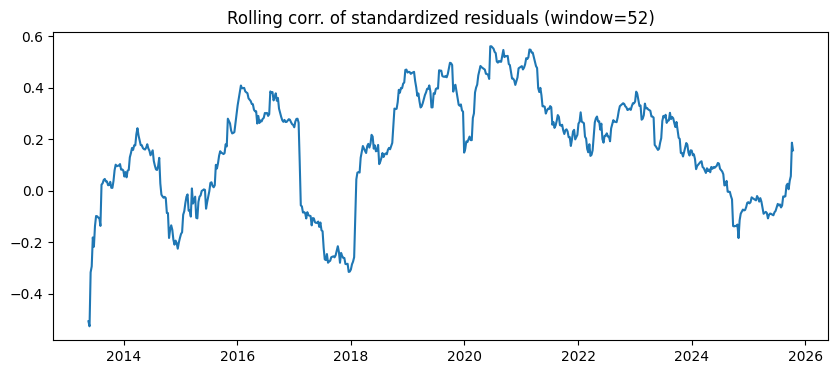

Durchschnittliche roll. Korrelation: 0.1641298860883948


In [63]:
roll_corr = volatility_spillover_garch(pair_data, window=52)
print("Durchschnittliche roll. Korrelation:", roll_corr.mean())


In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

def make_lags_from_pair(pair_data: pd.DataFrame, lags: int = 4):
    df = pair_data.copy()
    # Ziel: z.B. US_Ret durch CN-Lags vorhersagen
    for i in range(1, lags + 1):
        df[f"CN_lag{i}"] = df["CN_Ret"].shift(i)
        df[f"US_lag{i}"] = df["US_Ret"].shift(i)
    df = df.dropna().reset_index(drop=True)
    return df

def ml_predict_us_from_cn(pair_data: pd.DataFrame, lags: int = 4):
    df = make_lags_from_pair(pair_data, lags=lags)
    # Features: CN-Lags + optional US-Lags
    feature_cols = [f"CN_lag{i}" for i in range(1, lags+1)] + \
                   [f"US_lag{i}" for i in range(1, lags+1)]
    X = df[feature_cols].values
    y = df["US_Ret"].values

    tscv = TimeSeriesSplit(n_splits=5)
    preds = np.zeros_like(y)
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=120,
            max_depth=3,
            random_state=42,
        )
        model.fit(X_train, y_train)
        preds[test_idx] = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    print(f"XGBoost (US_Ret ~ CN/US lags) RMSE={rmse:.5f}  R2={r2:.4f}")
    return df, preds


In [65]:
ml_df, ml_preds = ml_predict_us_from_cn(pair_data, lags=4)


XGBoost (US_Ret ~ CN/US lags) RMSE=0.03432  R2=-0.2418


In [66]:
results = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        try:
            pair_data = make_pair_timeseries(friday_df, merged_weekly_cn, us_name, cn_name)
            if len(pair_data) < 60:  # etwas Mindestlänge
                print(f"Zu kurz: {us_name} – {cn_name} ({len(pair_data)})")
                continue

            # VAR + Granger
            var_res = VAR(pair_data[["US_Ret", "CN_Ret"]].set_index(pair_data["Date"])).fit(4)
            # einfacher Granger-Wrapper:
            g_cn_us = grangercausalitytests(pair_data[["US_Ret", "CN_Ret"]], maxlag=4, verbose=False)
            g_us_cn = grangercausalitytests(pair_data[["CN_Ret", "US_Ret"]], maxlag=4, verbose=False)

            # minimalen p-Wert rausziehen
            p_cn_us = min([g_cn_us[lag][0]["ssr_ftest"][1] for lag in g_cn_us])
            p_us_cn = min([g_us_cn[lag][0]["ssr_ftest"][1] for lag in g_us_cn])

            # FEVD
            total_spill, spill_df = dy_spillover_from_var(var_res, h=10)
            cn_to_us_share = spill_df.loc["US_recipient", "CN_source"]
            us_to_cn_share = spill_df.loc["CN_recipient", "US_source"]

            results.append({
                "US_Index": us_name,
                "CN_Index": cn_name,
                "n_obs": len(pair_data),
                "p_CN_to_US": p_cn_us,
                "p_US_to_CN": p_us_cn,
                "FEVD_CN_to_US": cn_to_us_share,
                "FEVD_US_to_CN": us_to_cn_share,
                "FEVD_total": total_spill,
            })

        except Exception as e:
            print(f"Fehler bei {us_name} – {cn_name}: {e}")

spillover_results = pd.DataFrame(results).sort_values(
    ["p_CN_to_US", "p_US_to_CN", "FEVD_CN_to_US"]
)
display(spillover_results)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: Futur

Zu kurz: NQ Internet – ELECTRONIC EQUIPMENT INDEX (35)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: Futur

,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN,FEVD_CN_to_US,FEVD_US_to_CN,FEVD_total
15,NQ Industrial,SSE Upstream Industry Index,711,0.060410,0.014972,0.056152,0.061079,0.058615
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631,0.070718,0.075728,0.065156,0.063155,0.064156
5,NQ Biotechnology,CSI WIND Biotechnology Index,514,0.176380,0.356975,0.050244,0.052938,0.051591
18,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.180120,0.000028,0.004529,0.004008,0.004268
17,NQ Industrial,SSE Downstream Industry Index,711,0.235066,0.008444,0.066966,0.070855,0.068911
14,NQ Internet,Information equipment,185,0.245088,0.015401,0.009719,0.061681,0.035700
6,NQ Computer,SSE Information Technology Sector index,825,0.257379,0.003075,0.062850,0.076836,0.069843
12,NQ Internet,CSI Information Technology index,1319,0.276927,0.000317,0.077844,0.095002,0.086423
13,NQ Internet,SZSE Information Technology Sector Index,659,0.282728,0.003350,0.082906,0.100956,0.091931
11,NQ Internet,SSE Information Technology Sector index,659,0.285395,0.028890,0.067820,0.083311,0.075566
